Use a classifier to evaluate the cut-off of high-weighting bands

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [7]:
import pickle
import numpy as np
import pandas as pd
from pymongo import MongoClient

import seaborn as sns
import matplotlib.pyplot as plt

import smote_variants as sv
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import utils
from sklearn.model_selection import StratifiedShuffleSplit

from utils import *

In [8]:
matfile = '/Users/bogao/DataFiles/new landscape/data/all_bands_weight.pkl'
labelfile = '/Users/bogao/DataFiles/new landscape/data/all_bands_label.pkl'
dlabelfile = '/Users/bogao/DataFiles/new landscape/data/all_bands_disease_label.pkl'
bandfile = '/Users/bogao/DataFiles/new landscape/data/bands.pkl'
slabelfile = '/Users/bogao/DataFiles/new landscape/files/all_bands_subtype_label.pkl'
featfile = '/Users/bogao/DataFiles/new landscape/data/all_bands.pkl'

with open(matfile, 'rb') as fmat, open(labelfile, 'rb') as flab, open(bandfile, 'rb') as fbd, open(dlabelfile, 'rb') as fdl, open(slabelfile, 'rb') as fsl, open(featfile, 'rb') as ff:
    data = pickle.load(fmat)
    labels = pickle.load(flab)
    bands = pickle.load(fbd)
    disease_labels = pickle.load(fdl)
    subtypes = pickle.load(fsl)
    fm = pickle.load(ff)
    
genefile =  '/Users/bogao/DataFiles/Data/genome/genes.tsv'
genes = pd.read_csv(genefile, sep='\t', names=['gene_id', 'name', 'chr','start','end', 'symbol'], header=0)
postive_data = np.maximum(data, 0)


## Test distribution of values

### using direct codes

Disease name from codes

In [20]:
codes, counts = np.unique(disease_labels, return_counts=True)
df = pd.DataFrame({'code':codes,'count':counts}).sort_values('count', ascending=False)

df = df[(df['count']>50) & (-df['code'].isin(['Others', 'None']))]

disease_names = df.code.tolist()

Check the value distribution of each label

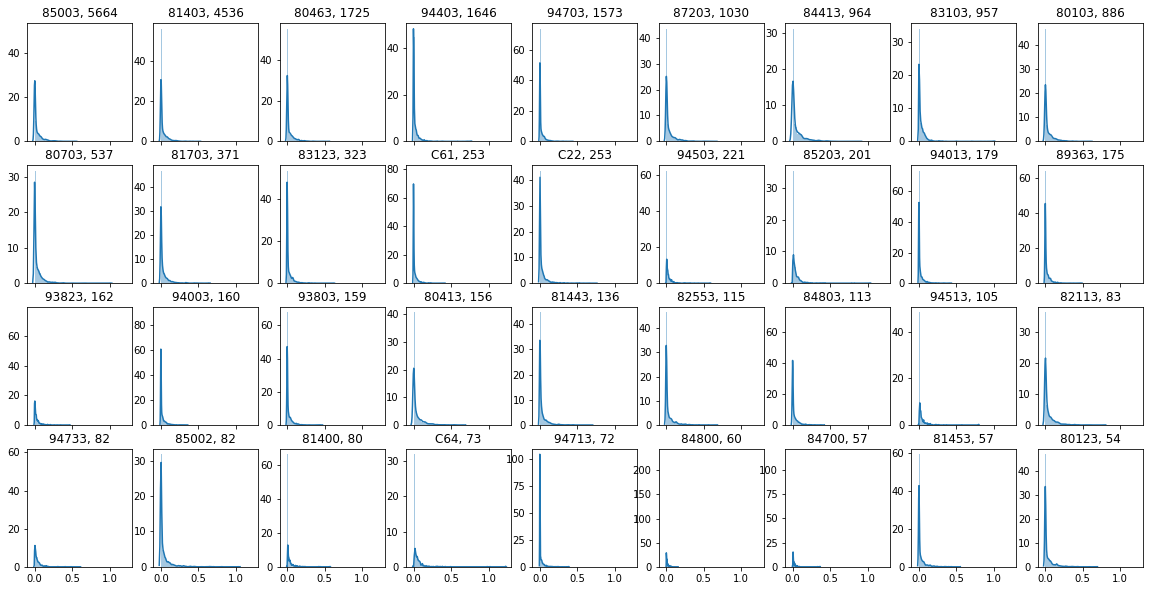

In [58]:
high_impact_bands = [False] * 1622

sig_thresh = 0.2
fig, axs = plt.subplots(4, 9, figsize=(20, 10), sharex=True, sharey=False)
r,c = 0, 0
for dname in disease_names:
    disease_data = postive_data[disease_labels == dname]
    sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]
    
    sns.distplot(sigsum, ax=axs[r, c])
    axs[r, c].set_title('{}, {}'.format(dname, int(df.loc[df.code == dname  , 'count'])))
    if c == 8:
        r += 1
        c = 0
    else:
        c += 1
    
    high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

### Using merged subtype names

Disease names from curation

In [77]:
disease_names = list(np.unique(subtypes['disease']))

disease_names.remove('NA')

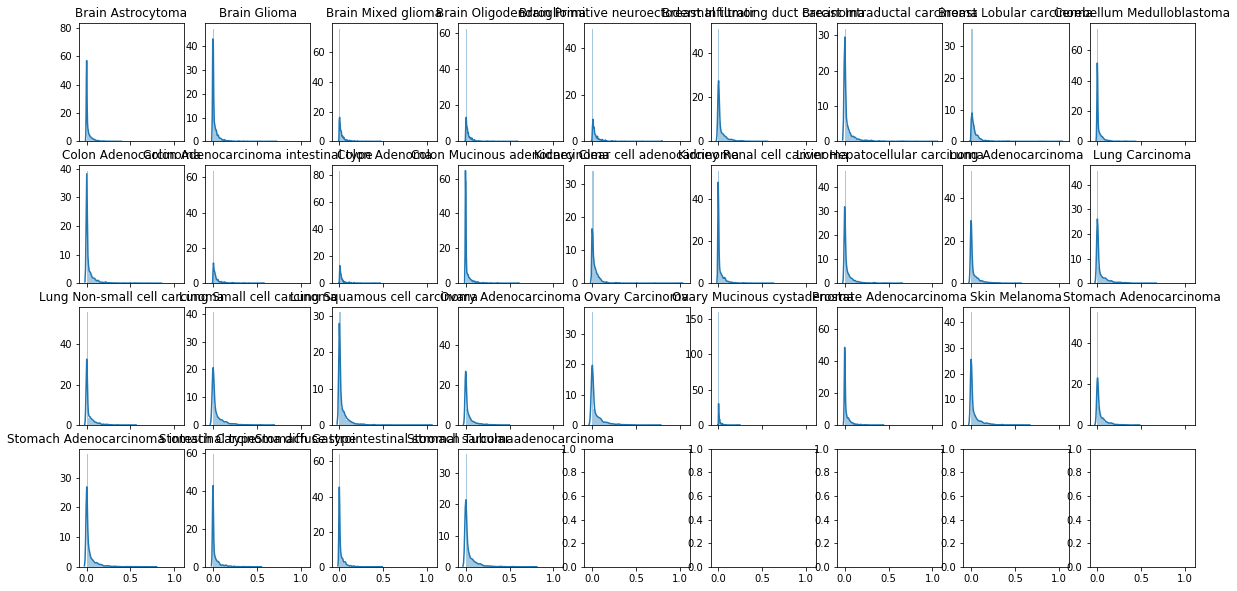

In [83]:
high_impact_bands = [False] * 1622

sig_thresh = 0.2
fig, axs = plt.subplots(4, 9, figsize=(20, 10), sharex=True, sharey=False)
r,c = 0, 0
for dname in disease_names:
    disease_data = postive_data[subtypes['disease'] == dname]
    sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]
    
    sns.distplot(sigsum, ax=axs[r, c])
    axs[r, c].set_title('{}'.format(dname))
    if c == 8:
        r += 1
        c = 0
    else:
        c += 1
    
    high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

## Use a classifier to evaluate the best threshold (1-fold)

In [11]:
disease_names = list(np.unique(subtypes['disease']))
disease_names.remove('NA')

In [18]:
all_results = []
all_high_filters = []

In [21]:
for sig_thresh in np.arange(0, 0.32, 0.02):

    
    # find high impact bands
    high_impact_bands = [False] * 1622

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

    # prepare feature matrix
    names = pd.DataFrame(np.unique(subtypes['disease'], return_counts=True)).transpose()
    names = names.rename(columns={0:'disease',1:'count'})
    names = names[names['disease'] != 'NA']
    names = names.reset_index(drop=True)
    names['target'] = names.index 
    names = names[['disease', 'target']]

    dlt = pd.merge(subtypes, names, how='left', on='disease')

    d = fm[subtypes['disease'] != 'NA'][:,high_impact_bands]
    l = subtypes.loc[subtypes['disease'] != 'NA', 'disease'].to_numpy()
    t = dlt.loc[subtypes['disease'] != 'NA', 'target'].to_numpy().astype(int)
    n = names['disease'].to_numpy()

    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=-1))
    
    all_results.append(result)
    all_high_filters.append(high_impact_bands)

2020-09-03 17:55:38,692:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-03 17:55:38,699:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-03 17:55:38,707:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 17:55:47,560:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-03 17:55:47,573:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 17:55:57,855:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-03 17:55:57,870:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 17:56:12,584:INFO:MulticlassOversampling: Sampling mi

2020-09-03 18:00:42,540:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:02:45,204:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-03 18:02:45,209:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-03 18:02:45,215:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:02:50,521:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-03 18:02:50,527:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:02:56,590:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-03 18:02:56,600:INFO:ProWSyn: Running sampling via ('Pro

2020-09-03 18:06:03,695:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-03 18:06:03,759:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:07:37,636:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-03 18:07:37,640:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-03 18:07:37,644:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:07:41,753:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-03 18:07:41,759:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:07:46,290:INFO:MulticlassOversampling: Sampling m

2020-09-03 18:09:59,039:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:10:01,241:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-03 18:10:01,291:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:11:21,978:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-03 18:11:21,982:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-03 18:11:21,986:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:11:25,542:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-03 18:11:25,547:INFO:ProWSyn: Running sampling via ('P

2020-09-03 18:13:29,315:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-03 18:13:29,365:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:13:31,609:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-03 18:13:31,648:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:14:50,934:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-03 18:14:50,938:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-03 18:14:50,942:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:14:53,945:INFO:MulticlassOversampling: Sampling 

2020-09-03 18:16:38,029:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:16:39,501:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-03 18:16:39,530:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:16:41,213:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-03 18:16:41,249:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:17:54,051:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-03 18:17:54,059:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-03 18:17:54,062:INFO:ProWSyn: Running

2020-09-03 18:19:29,557:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-03 18:19:29,582:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:19:31,570:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-03 18:19:31,598:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:19:32,892:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-03 18:19:32,926:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:20:40,712:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-03 18:20:40,716:INFO:MulticlassOversa

2020-09-03 18:22:04,748:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:22:06,183:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-03 18:22:06,208:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:22:07,412:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-03 18:22:07,441:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:22:08,708:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-03 18:22:08,731:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random

2020-09-03 18:24:28,040:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-03 18:24:28,060:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:24:30,870:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-03 18:24:30,889:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:24:32,506:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-03 18:24:32,531:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:24:33,588:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-03 18:24:33,610:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-03 18:26:36,052:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:26:37,997:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-03 18:26:38,015:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:26:39,011:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-03 18:26:39,034:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:26:40,534:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-03 18:26:40,557:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random

2020-09-03 18:28:37,121:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-03 18:28:37,137:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:28:38,097:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-03 18:28:38,113:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:28:39,028:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-03 18:28:39,044:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:28:41,093:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-03 18:28:41,119:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-03 18:30:29,012:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:30:30,603:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-03 18:30:30,621:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:30:32,121:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-03 18:30:32,135:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:30:33,105:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-03 18:30:33,124:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'rando

2020-09-03 18:32:10,296:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-03 18:32:10,309:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:32:11,200:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-03 18:32:11,215:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:32:12,560:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-03 18:32:12,575:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:32:13,390:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-03 18:32:13,403:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-03 18:33:41,285:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:33:43,443:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-03 18:33:43,454:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:33:44,780:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-03 18:33:44,792:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:33:46,946:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-03 18:33:46,956:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-03 18:35:09,354:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-03 18:35:09,363:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:35:10,662:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-03 18:35:10,671:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:35:11,594:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-03 18:35:11,603:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:35:12,338:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-03 18:35:12,348:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-03 18:36:22,695:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:36:24,203:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-03 18:36:24,212:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:36:26,997:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-03 18:36:27,005:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:36:27,729:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-03 18:36:27,738:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_

2020-09-03 18:37:36,115:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-03 18:37:36,122:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:37:37,543:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-03 18:37:37,555:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:37:39,841:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-03 18:37:39,850:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-03 18:37:40,990:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-03 18:37:41,004:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

In [37]:
mtr = [[],[],[],[],[]]

for r,f in zip(all_results, all_high_filters):
    r = r[0]
    mtr[0].append(metrics.accuracy_score(r[0], r[1]))
    mtr[1].append(metrics.precision_score(r[0], r[1], average='macro'))
    mtr[2].append(metrics.recall_score(r[0], r[1], average='macro'))
    mtr[3].append(metrics.f1_score(r[0], r[1], average='macro'))
    mtr[4].append(sum(f))

pd.DataFrame({'thresh': np.arange(0, 0.32, 0.02),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0.00,0.611398,0.493815,0.474734,0.472964,1543
1,0.02,0.617631,0.503137,0.460399,0.469349,957
2,0.04,0.609439,0.490198,0.473216,0.471062,721
3,0.06,0.609083,0.505367,0.473661,0.476577,630
4,0.08,0.601603,0.490144,0.466348,0.463042,533
5,0.10,0.595726,0.471752,0.457028,0.456069,470
6,0.12,0.608014,0.481397,0.443395,0.449770,413
7,0.14,0.587533,0.440559,0.440108,0.431926,350
8,0.16,0.586999,0.443985,0.439814,0.430252,310
9,0.18,0.587177,0.442382,0.440273,0.432869,266


In [58]:
for r, t in zip(all_results, np.arange(0, 0.32, 0.02)):
    
    r = r[0]
    if t == 0:
        classes = evaluate_classes(r, names=dd['name'], sort='Label', ascending=True)
        classes = classes[['Label','F1-score']]
        classes = classes.rename(columns = {'F1-score':str(t)})
    else:
        c = evaluate_classes(r, names=dd['name'], sort='Label', ascending=True)
        c = c[['Label','F1-score']]
        c = c.rename(columns = {'F1-score':str(t)})

        classes = pd.merge(classes, c, how='left', on='Label')

classes


,Label,0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3
0,Brain Astrocytoma,0.295567,0.315789,0.313514,0.337349,0.295858,0.340659,0.335135,0.330097,0.274725,0.279570,0.220690,0.283105,0.334928,0.297030,0.278351,0.233645
1,Brain Glioma,0.715477,0.726606,0.710714,0.710909,0.717117,0.716228,0.740608,0.731490,0.709562,0.710403,0.715789,0.725044,0.687500,0.689165,0.688057,0.664855
2,Brain Mixed glioma,0.256410,0.326531,0.282051,0.247423,0.180000,0.177778,0.244444,0.177215,0.242991,0.195652,0.318584,0.250000,0.231579,0.127660,0.229885,0.250000
3,Brain Oligodendroglioma,0.412214,0.372093,0.457143,0.466165,0.376812,0.517986,0.484848,0.421053,0.435484,0.431655,0.496000,0.483871,0.432000,0.394161,0.387597,0.451613
4,Brain Primitive neuroectodermal tumor,0.244898,0.142857,0.130435,0.333333,0.225806,0.285714,0.295082,0.233333,0.235294,0.218750,0.266667,0.235294,0.246154,0.190476,0.210526,0.269231
5,Breast Infiltrating duct carcinoma,0.595163,0.590131,0.580376,0.578947,0.570010,0.565032,0.578288,0.524313,0.546793,0.510730,0.540373,0.519737,0.562780,0.527897,0.529349,0.543502
6,Breast Intraductal carcinoma,0.680000,0.666667,0.851852,0.692308,0.734694,0.653846,0.680851,0.745098,0.571429,0.600000,0.523810,0.622951,0.680000,0.500000,0.760000,0.745098
7,Breast Lobular carcinoma,0.657343,0.650794,0.609375,0.537313,0.535433,0.552846,0.598425,0.586667,0.489209,0.578947,0.619718,0.579310,0.463415,0.517483,0.503145,0.471429
8,Cerebellum Medulloblastoma,0.713568,0.716724,0.716918,0.693844,0.708714,0.678718,0.699588,0.696246,0.694915,0.693467,0.681704,0.693739,0.678421,0.691126,0.690355,0.679934
9,Colon Adenocarcinoma,0.703879,0.720737,0.719855,0.677333,0.695733,0.693989,0.703802,0.705775,0.704995,0.701657,0.682439,0.689030,0.689152,0.672300,0.696143,0.697111


## Use a classifier to evaluate the best threshold (3-folds)

prepare labels

In [59]:
names = pd.DataFrame(np.unique(subtypes['disease'], return_counts=True)).transpose()
names = names.rename(columns={0:'disease',1:'count'})
names = names[names['disease'] != 'NA']
names = names.reset_index(drop=True)
names['target'] = names.index 
names = names[['disease', 'target']]

dlt = pd.merge(subtypes, names, how='left', on='disease')

l = subtypes.loc[subtypes['disease'] != 'NA', 'disease'].to_numpy()
t = dlt.loc[subtypes['disease'] != 'NA', 'target'].to_numpy().astype(int)
n = names['disease'].to_numpy()

In [60]:
all_results_3 = []
all_high_filters_3 = []

for sig_thresh in np.arange(0, 0.32, 0.02):

    
    # find high impact bands
    high_impact_bands = [False] * 1622

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

    # prepare feature matrix
    d = fm[subtypes['disease'] != 'NA'][:,high_impact_bands]
    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=3, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=-1))

    all_results_3.append(result)
    all_high_filters_3.append(high_impact_bands)

2020-09-04 07:54:13,554:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 07:54:13,561:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 07:54:13,570:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 07:54:22,244:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 07:54:22,257:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 07:54:33,206:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-04 07:54:33,225:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 07:54:48,686:INFO:MulticlassOversampling: Sampling mi

2020-09-04 07:59:18,878:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:01:22,174:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 08:01:22,183:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 08:01:22,193:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:01:30,656:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 08:01:30,670:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:01:40,998:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-04 08:01:41,018:INFO:ProWSyn: Running sampling via ('Pro

2020-09-04 08:06:28,776:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 08:06:28,860:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:08:29,068:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 08:08:29,077:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 08:08:29,086:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:08:37,624:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 08:08:37,639:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:08:47,548:INFO:MulticlassOversampling: Sampling m

2020-09-04 08:13:27,907:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:13:32,864:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 08:13:32,951:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:15:36,720:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 08:15:36,725:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 08:15:36,731:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:15:42,064:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 08:15:42,084:INFO:ProWSyn: Running sampling via ('P

2020-09-04 08:18:44,218:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 08:18:44,272:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:18:47,002:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 08:18:47,065:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:20:17,527:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 08:20:17,532:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 08:20:17,539:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:20:22,946:INFO:MulticlassOversampling: Sampling 

2020-09-04 08:23:21,464:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:23:25,444:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 08:23:25,501:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:23:27,877:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 08:23:27,930:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:24:59,927:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 08:24:59,933:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 08:24:59,939:INFO:ProWSyn: Running

2020-09-04 08:28:05,392:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 08:28:05,445:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:28:09,011:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 08:28:09,067:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:28:13,341:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 08:28:13,403:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:29:45,574:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 08:29:45,581:INFO:MulticlassOversa

2020-09-04 08:32:08,666:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:32:11,096:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 08:32:11,145:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:32:13,602:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 08:32:13,649:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:32:15,451:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 08:32:15,500:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random

2020-09-04 08:35:55,647:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 08:35:55,699:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:35:57,824:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 08:35:57,871:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:36:00,265:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 08:36:00,312:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:36:06,372:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 08:36:06,415:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-04 08:39:42,214:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:39:44,881:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 08:39:44,922:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:39:47,174:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 08:39:47,217:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:39:50,076:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 08:39:50,121:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random

2020-09-04 08:43:19,643:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 08:43:19,680:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:43:21,737:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 08:43:21,779:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:43:23,464:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 08:43:23,504:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:43:26,212:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 08:43:26,252:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-04 08:46:43,467:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:46:45,269:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 08:46:45,310:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:46:50,293:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 08:46:50,329:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:46:55,114:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 08:46:55,153:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'rando

2020-09-04 08:50:17,273:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 08:50:17,312:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:50:19,342:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 08:50:19,380:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:50:22,469:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 08:50:22,505:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:50:25,162:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 08:50:25,200:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-04 08:53:24,680:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:53:26,461:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 08:53:26,492:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:53:29,615:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 08:53:29,642:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:53:32,010:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 08:53:32,039:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 08:56:29,400:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 08:56:29,425:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:56:31,180:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 08:56:31,211:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:56:32,980:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 08:56:33,007:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:56:35,361:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 08:56:35,388:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 08:59:28,997:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:59:31,058:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 08:59:31,082:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:59:34,932:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 08:59:34,962:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 08:59:38,240:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 08:59:38,267:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_

2020-09-04 09:02:26,410:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 09:02:26,433:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:02:29,352:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 09:02:29,379:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:02:31,385:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 09:02:31,416:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:02:35,246:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 09:02:35,272:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 09:05:13,286:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:05:15,438:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 09:05:15,462:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:05:17,489:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 09:05:17,513:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:05:20,835:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 09:05:20,860:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 09:08:04,119:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 09:08:04,142:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:08:08,110:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 09:08:08,132:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:08:10,131:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 09:08:10,160:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:08:11,878:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 09:08:11,903:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-04 09:10:41,132:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:10:42,922:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 09:10:42,941:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:10:45,514:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 09:10:45,534:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:10:48,481:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 09:10:48,504:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 09:13:18,394:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 09:13:18,413:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:13:20,306:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 09:13:20,330:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:13:24,503:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 09:13:24,523:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:13:26,927:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 09:13:26,948:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-04 09:15:52,935:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:15:54,881:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 09:15:54,905:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:15:56,689:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 09:15:56,710:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:15:59,872:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 09:15:59,892:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random

2020-09-04 09:18:19,745:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 09:18:19,760:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:18:22,370:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 09:18:22,386:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:18:24,002:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 09:18:24,020:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:18:26,088:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 09:18:26,106:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-04 09:20:34,248:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:20:37,464:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 09:20:37,479:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:20:38,957:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 09:20:38,973:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:20:40,586:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 09:20:40,603:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'rando

2020-09-04 09:22:47,600:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 09:22:47,616:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:22:49,769:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 09:22:49,784:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:22:51,305:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 09:22:51,323:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:22:52,848:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 09:22:52,866:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-04 09:24:57,382:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:24:59,244:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 09:24:59,258:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:25:00,939:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 09:25:00,953:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:25:02,322:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 09:25:02,336:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_

2020-09-04 09:26:58,732:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 09:26:58,745:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:27:01,155:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 09:27:01,170:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:27:03,405:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 09:27:03,419:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:27:04,767:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 09:27:04,782:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 09:29:02,111:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:29:05,204:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 09:29:05,218:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:29:06,739:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 09:29:06,754:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:29:08,674:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 09:29:08,688:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 09:31:03,773:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 09:31:03,785:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:31:06,063:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 09:31:06,075:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:31:07,348:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 09:31:07,360:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:31:09,739:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 09:31:09,753:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-04 09:32:57,335:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:32:59,069:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 09:32:59,080:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:33:00,591:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 09:33:00,604:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:33:03,946:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 09:33:03,959:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_sta

2020-09-04 09:34:54,008:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 09:34:54,018:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:34:56,859:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 09:34:56,870:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:34:58,553:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 09:34:58,565:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:35:00,257:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 09:35:00,270:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proporti

2020-09-04 09:36:42,867:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:36:44,537:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 09:36:44,547:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:36:45,901:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 09:36:45,911:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:36:47,253:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 09:36:47,263:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state

2020-09-04 09:38:25,509:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 09:38:25,518:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:38:27,128:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 09:38:27,137:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:38:28,538:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 09:38:28,549:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:38:30,566:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 09:38:30,576:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proport

2020-09-04 09:40:05,024:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:40:07,461:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 09:40:07,470:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:40:08,882:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 09:40:08,892:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:40:10,850:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 09:40:10,860:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_stat

2020-09-04 09:41:44,649:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 09:41:44,656:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:41:46,515:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 09:41:46,522:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:41:48,563:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 09:41:48,572:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:41:49,862:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 09:41:49,871:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proport

2020-09-04 09:43:23,168:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:43:24,505:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 09:43:24,513:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:43:25,884:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 09:43:25,892:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:43:27,599:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 09:43:27,608:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_stat

2020-09-04 09:45:00,546:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 09:45:00,553:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:45:02,005:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 09:45:02,012:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:45:03,815:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 09:45:03,823:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:45:05,060:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 09:45:05,069:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proport

2020-09-04 09:46:33,650:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:46:35,117:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 09:46:35,122:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:46:36,306:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 09:46:36,312:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:46:38,005:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 09:46:38,012:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_sta

2020-09-04 09:48:01,674:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 09:48:01,680:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:48:03,087:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 09:48:03,093:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:48:04,256:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 09:48:04,263:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:48:05,489:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 09:48:05,496:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propor

2020-09-04 09:49:26,690:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:49:28,651:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 09:49:28,658:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:49:30,115:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 09:49:30,121:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:49:31,319:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 09:49:31,326:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_sta

2020-09-04 09:50:51,599:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 09:50:51,604:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:50:53,116:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 09:50:53,122:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:50:54,379:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 09:50:54,384:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:50:56,000:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 09:50:56,006:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-04 09:52:13,954:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:52:15,933:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 09:52:15,937:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:52:17,347:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 09:52:17,353:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:52:18,634:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 09:52:18,640:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_st

2020-09-04 09:53:38,568:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 09:53:38,573:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:53:40,461:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 09:53:40,465:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:53:41,825:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 09:53:41,831:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:53:43,469:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 09:53:43,475:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-04 09:54:54,176:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:54:55,904:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 09:54:55,907:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:54:57,654:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 09:54:57,659:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:54:58,958:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 09:54:58,962:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_

2020-09-04 09:56:14,989:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 09:56:14,992:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:56:16,748:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 09:56:16,751:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:56:18,484:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 09:56:18,488:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:56:19,969:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 09:56:19,973:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-04 09:57:24,254:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:57:26,018:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 09:57:26,021:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:57:27,828:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 09:57:27,831:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:57:29,560:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 09:57:29,564:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_st

2020-09-04 09:58:36,250:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-04 09:58:36,252:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:58:37,906:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 09:58:37,909:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:58:39,557:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 09:58:39,559:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:58:41,083:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 09:58:41,086:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 09:59:44,795:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:59:46,122:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-04 09:59:46,125:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:59:47,731:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 09:59:47,734:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 09:59:49,363:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 09:59:49,365:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 10:00:54,994:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-04 10:00:54,996:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:00:56,278:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-04 10:00:56,281:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:00:57,870:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 10:00:57,872:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:00:59,417:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 10:00:59,419:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

In [68]:
mtr = [[],[],[],[],[]]
n = 3
for res,f in zip(all_results_3, all_high_filters_3):
    acc, pre, rec, f1 = 0, 0, 0, 0
    for r in res:
        acc += metrics.accuracy_score(r[0], r[1])
        pre += metrics.precision_score(r[0], r[1], average='macro')
        rec += metrics.recall_score(r[0], r[1], average='macro')
        f1 += metrics.f1_score(r[0], r[1], average='macro')
    
    mtr[0].append(acc/n)
    mtr[1].append(pre/n)
    mtr[2].append(rec/n)
    mtr[3].append(f1/n)
    mtr[4].append(sum(f))
    
#     r = res[2]
#     mtr[0].append(metrics.accuracy_score(r[0], r[1]))
#     mtr[1].append(metrics.precision_score(r[0], r[1], average='macro'))
#     mtr[2].append(metrics.recall_score(r[0], r[1], average='macro'))
#     mtr[3].append(metrics.f1_score(r[0], r[1], average='macro'))
#     mtr[4].append(sum(f))
    
pd.DataFrame({'thresh': np.arange(0, 0.32, 0.02),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})
    



,thresh,accuracy,precision,recall,f1,features
0,0.00,0.622321,0.511057,0.476655,0.483873,1543
1,0.02,0.615138,0.512534,0.469903,0.475891,957
2,0.04,0.605343,0.480725,0.456426,0.456530,721
3,0.06,0.609914,0.469939,0.451480,0.449884,630
4,0.08,0.598397,0.470169,0.450386,0.449420,533
5,0.10,0.597744,0.468398,0.446481,0.445465,470
6,0.12,0.605996,0.472816,0.452545,0.452792,413
7,0.14,0.595548,0.456685,0.437459,0.436685,350
8,0.16,0.589789,0.451644,0.438998,0.435460,310
9,0.18,0.589908,0.442874,0.442588,0.433452,266


## Final fine grid search for the best cut-off

In [70]:
np.arange(0, 0.08, 0.005).shape

(16,)

In [71]:
np.arange(0, 0.32, 0.02).shape

(16,)

In [72]:
all_results_best = []
all_high_filters_best = []

for sig_thresh in np.arange(0, 0.08, 0.005):

    
    # find high impact bands
    high_impact_bands = [False] * 1622

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

    # prepare feature matrix
    d = fm[subtypes['disease'] != 'NA'][:,high_impact_bands]
    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=5, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=-1))

    all_results_best.append(result)
    all_high_filters_best.append(high_impact_bands)

2020-09-04 10:37:45,245:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 10:37:45,252:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 10:37:45,261:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:37:53,949:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 10:37:53,963:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:38:04,091:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-04 10:38:04,106:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:38:18,614:INFO:MulticlassOversampling: Sampling mi

2020-09-04 10:42:50,888:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:44:50,583:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 10:44:50,592:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 10:44:50,602:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:44:59,294:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 10:44:59,308:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:45:09,500:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-04 10:45:09,516:INFO:ProWSyn: Running sampling via ('Pro

2020-09-04 10:49:58,158:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 10:49:58,277:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:52:00,409:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 10:52:00,417:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 10:52:00,427:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:52:09,136:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 10:52:09,150:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:52:19,133:INFO:MulticlassOversampling: Sampling m

2020-09-04 10:56:57,625:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:57:02,957:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 10:57:03,047:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:59:00,916:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 10:59:00,924:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 10:59:00,934:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 10:59:09,424:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 10:59:09,438:INFO:ProWSyn: Running sampling via ('P

2020-09-04 11:03:59,961:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 11:04:00,044:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:04:05,239:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 11:04:05,326:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:06:06,278:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 11:06:06,286:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 11:06:06,295:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:06:14,960:INFO:MulticlassOversampling: Sampling 

2020-09-04 11:10:59,686:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:11:05,263:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 11:11:05,351:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:11:08,788:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 11:11:08,877:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:13:11,467:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 11:13:11,473:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 11:13:11,481:INFO:ProWSyn: Running

2020-09-04 11:17:18,072:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 11:17:18,141:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:17:24,269:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 11:17:24,343:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:17:31,780:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 11:17:31,856:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:19:18,674:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 11:19:18,683:INFO:MulticlassOversa

2020-09-04 11:23:22,299:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:23:25,785:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 11:23:25,855:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:23:29,656:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 11:23:29,733:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:23:32,956:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 11:23:33,032:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random

2020-09-04 11:29:20,683:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 11:29:20,753:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:29:23,844:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 11:29:23,917:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:29:29,380:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 11:29:29,452:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:29:32,404:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 11:29:32,480:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-04 11:35:22,035:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:35:25,749:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 11:35:25,819:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:35:28,957:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 11:35:29,029:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:35:32,715:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 11:35:32,789:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random

2020-09-04 11:41:21,458:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 11:41:21,528:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:41:26,271:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 11:41:26,341:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:41:30,350:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 11:41:30,424:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:41:34,550:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 11:41:34,634:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-04 11:46:54,478:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:46:58,559:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 11:46:58,617:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:47:02,677:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 11:47:02,740:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:47:07,880:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 11:47:07,944:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'rando

2020-09-04 11:52:23,036:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 11:52:23,088:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:52:26,377:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 11:52:26,433:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:52:30,090:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 11:52:30,152:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:52:33,114:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 11:52:33,176:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-04 11:57:54,121:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:57:58,022:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 11:57:58,076:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:58:02,030:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 11:58:02,086:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 11:58:05,127:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 11:58:05,189:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 12:03:21,098:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 12:03:21,148:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:03:24,122:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 12:03:24,174:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:03:27,706:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 12:03:27,762:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:03:32,243:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 12:03:32,306:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 12:08:47,981:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:08:52,164:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 12:08:52,214:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:08:55,036:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 12:08:55,088:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:08:59,027:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 12:08:59,083:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_

2020-09-04 12:14:00,976:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 12:14:01,024:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:14:05,020:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 12:14:05,070:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:14:07,821:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 12:14:07,870:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:14:13,155:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 12:14:13,204:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 12:19:06,225:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:19:12,309:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 12:19:12,357:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:19:17,720:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 12:19:17,770:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:19:21,322:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 12:19:21,368:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 12:24:16,389:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 12:24:16,433:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:24:21,872:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 12:24:21,920:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:24:26,153:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 12:24:26,202:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:24:28,939:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 12:24:28,987:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-04 12:29:11,381:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:29:15,270:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 12:29:15,314:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:29:19,020:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 12:29:19,066:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:29:23,831:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 12:29:23,881:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 12:34:13,316:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 12:34:13,361:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:34:18,652:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 12:34:18,695:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:34:23,112:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 12:34:23,160:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:34:27,014:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 12:34:27,064:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-04 12:39:07,036:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:39:12,632:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 12:39:12,679:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:39:16,406:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 12:39:16,447:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:39:20,188:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 12:39:20,230:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random

2020-09-04 12:43:48,888:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 12:43:48,926:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:43:52,664:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 12:43:52,713:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:43:56,930:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 12:43:56,974:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:44:01,133:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 12:44:01,176:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-04 12:48:22,072:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:48:26,195:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 12:48:26,233:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:48:31,282:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 12:48:31,328:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:48:35,410:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 12:48:35,454:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'rando

2020-09-04 12:53:04,898:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 12:53:04,939:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:53:08,526:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 12:53:08,564:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:53:13,651:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 12:53:13,696:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:53:17,534:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 12:53:17,579:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-04 12:57:44,910:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:57:48,392:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 12:57:48,432:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:57:52,739:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 12:57:52,780:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 12:57:56,623:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 12:57:56,668:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_

2020-09-04 13:02:10,391:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 13:02:10,427:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:02:14,165:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 13:02:14,200:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:02:18,589:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 13:02:18,628:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:02:22,872:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 13:02:22,925:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 13:06:28,720:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:06:33,573:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 13:06:33,609:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:06:37,034:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 13:06:37,069:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:06:41,143:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 13:06:41,182:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 13:10:52,156:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 13:10:52,192:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:10:57,218:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 13:10:57,254:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:11:03,118:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 13:11:03,153:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:11:06,632:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-04 13:11:06,671:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-04 13:15:17,379:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:15:23,455:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 13:15:23,488:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:15:27,765:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 13:15:27,801:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:15:31,412:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 13:15:31,447:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_sta

2020-09-04 13:19:43,112:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 13:19:43,143:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:19:48,017:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 13:19:48,049:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:19:52,281:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 13:19:52,317:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:19:55,659:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-04 13:19:55,695:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proporti

2020-09-04 13:23:54,716:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:23:59,155:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 13:23:59,181:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:24:03,192:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 13:24:03,223:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:24:07,856:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 13:24:07,885:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state

2020-09-04 13:28:03,254:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 13:28:03,280:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:28:07,412:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 13:28:07,440:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:28:13,742:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 13:28:13,769:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:28:18,489:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-04 13:28:18,523:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proport

2020-09-04 13:32:10,805:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:32:15,441:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 13:32:15,468:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:32:20,963:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 13:32:20,992:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:32:24,977:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 13:32:25,004:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_stat

2020-09-04 13:36:21,309:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 13:36:21,334:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:36:27,604:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 13:36:27,630:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:36:31,844:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 13:36:31,870:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:36:36,375:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-04 13:36:36,403:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proport

2020-09-04 13:40:23,744:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:40:28,353:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 13:40:28,378:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:40:33,133:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 13:40:33,159:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:40:37,530:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 13:40:37,555:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_stat

2020-09-04 13:44:25,830:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 13:44:25,850:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:44:30,403:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 13:44:30,426:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:44:34,742:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 13:44:34,767:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:44:39,722:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-04 13:44:39,747:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proport

2020-09-04 13:48:18,417:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:48:23,676:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 13:48:23,697:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:48:29,013:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 13:48:29,035:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:48:33,538:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 13:48:33,563:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_sta

2020-09-04 13:52:14,866:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 13:52:14,885:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:52:20,140:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 13:52:20,163:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:52:24,752:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 13:52:24,775:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:52:30,885:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-04 13:52:30,910:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propor

2020-09-04 13:56:08,334:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:56:14,804:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 13:56:14,825:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:56:20,119:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 13:56:20,141:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 13:56:24,760:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 13:56:24,782:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_sta

2020-09-04 14:00:06,281:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 14:00:06,300:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:00:12,621:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 14:00:12,642:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:00:17,745:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 14:00:17,768:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:00:22,314:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-04 14:00:22,336:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-04 14:03:51,964:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:04:01,746:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 14:04:01,764:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:04:07,701:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 14:04:07,722:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:04:13,247:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 14:04:13,268:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_st

2020-09-04 14:07:42,941:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 14:07:42,960:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:07:52,638:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 14:07:52,658:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:07:59,044:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 14:07:59,064:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:08:04,278:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-04 14:08:04,300:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-04 14:11:21,087:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:11:30,128:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 14:11:30,149:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:11:39,726:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 14:11:39,744:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:11:45,731:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 14:11:45,752:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_

2020-09-04 14:15:07,262:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 14:15:07,276:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:15:16,381:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 14:15:16,400:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:15:25,900:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 14:15:25,918:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:15:31,818:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-04 14:15:31,838:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-04 14:18:46,965:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:18:56,018:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 14:18:56,037:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:19:04,984:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 14:19:05,002:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:19:14,648:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 14:19:14,666:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_st

2020-09-04 14:22:36,100:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-04 14:22:36,114:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:22:44,976:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 14:22:44,991:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:22:53,634:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 14:22:53,650:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:23:02,883:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-04 14:23:02,900:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 14:26:12,206:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:26:19,686:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-04 14:26:19,701:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:26:28,490:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 14:26:28,504:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:26:37,172:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 14:26:37,188:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 14:29:51,416:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-04 14:29:51,431:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:29:59,160:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-04 14:29:59,176:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:30:08,019:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 14:30:08,034:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:30:16,627:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-04 14:30:16,643:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 14:33:26,297:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:33:33,188:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-04 14:33:33,201:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:33:40,784:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-04 14:33:40,799:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:33:49,543:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 14:33:49,557:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 14:37:08,701:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-04 14:37:08,714:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:37:15,564:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-04 14:37:15,578:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:37:23,144:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-04 14:37:23,162:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:37:31,555:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-04 14:37:31,570:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-04 14:40:39,241:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:40:48,625:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-04 14:40:48,636:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:40:55,207:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-04 14:40:55,219:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:41:02,327:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-04 14:41:02,341:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_st

2020-09-04 14:44:14,182:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-04 14:44:14,193:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:44:23,558:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-04 14:44:23,568:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:44:30,178:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-04 14:44:30,189:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:44:37,173:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-04 14:44:37,186:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 14:47:38,008:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:47:45,852:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-04 14:47:45,864:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:47:54,856:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-04 14:47:54,867:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:48:01,721:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-04 14:48:01,733:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 14:51:11,167:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-04 14:51:11,175:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:51:19,017:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-04 14:51:19,028:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:51:28,006:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-04 14:51:28,016:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:51:34,976:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-04 14:51:34,987:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-04 14:54:37,043:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:54:43,146:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-04 14:54:43,155:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:54:50,662:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-04 14:54:50,674:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:54:59,606:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-04 14:54:59,617:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_st

2020-09-04 14:58:09,271:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-04 14:58:09,281:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:58:15,238:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-04 14:58:15,246:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:58:23,034:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-04 14:58:23,045:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 14:58:31,791:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-04 14:58:31,802:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propor

2020-09-04 15:01:37,553:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:01:41,534:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-04 15:01:41,542:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:01:47,522:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-04 15:01:47,530:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:01:55,251:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-04 15:01:55,263:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_stat

2020-09-04 15:05:05,420:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 15:05:05,425:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:05:09,428:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-04 15:05:09,436:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:05:15,271:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-04 15:05:15,280:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:05:22,953:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-04 15:05:22,964:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proport

2020-09-04 15:08:32,795:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:08:36,403:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 15:08:36,409:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:08:40,410:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-04 15:08:40,418:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:08:46,392:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-04 15:08:46,401:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
202

2020-09-04 15:12:00,313:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 15:12:00,319:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:12:03,971:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 15:12:03,976:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:12:08,027:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-04 15:12:08,034:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:12:13,800:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-04 15:12:13,809:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0350620

2020-09-04 15:15:27,241:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 15:15:27,245:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 15:15:27,250:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:15:30,753:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 15:15:30,758:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:15:34,656:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-04 15:15:34,663:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:15:40,486:INFO:MulticlassOversampling: Sampling mi

2020-09-04 15:17:38,993:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:18:54,570:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 15:18:54,575:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 15:18:54,580:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:18:58,155:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 15:18:58,160:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:19:02,096:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-04 15:19:02,103:INFO:ProWSyn: Running sampling via ('Pro

2020-09-04 15:21:09,167:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 15:21:09,205:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:22:25,018:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 15:22:25,056:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 15:22:25,060:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:22:28,415:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 15:22:28,421:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:22:32,304:INFO:MulticlassOversampling: Sampling m

2020-09-04 15:24:31,740:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:24:33,992:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 15:24:34,032:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:25:50,904:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 15:25:50,909:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 15:25:50,914:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:25:54,549:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-04 15:25:54,557:INFO:ProWSyn: Running sampling via ('P

2020-09-04 15:27:56,932:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 15:27:56,972:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:27:58,659:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 15:27:58,699:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:29:14,595:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 15:29:14,600:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 15:29:14,605:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:29:18,111:INFO:MulticlassOversampling: Sampling 

2020-09-04 15:31:19,517:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:31:21,851:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 15:31:21,893:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:31:23,687:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 15:31:23,733:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:32:41,421:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 15:32:41,425:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-04 15:32:41,429:INFO:ProWSyn: Running

2020-09-04 15:34:41,343:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 15:34:41,377:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:34:43,112:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 15:34:43,151:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:34:45,098:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 15:34:45,138:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:36:00,419:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-04 15:36:00,423:INFO:MulticlassOversa

2020-09-04 15:37:54,839:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:37:56,933:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 15:37:56,968:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:37:59,331:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 15:37:59,370:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:38:01,311:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 15:38:01,352:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random

2020-09-04 15:41:13,970:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 15:41:14,005:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:41:15,782:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 15:41:15,817:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:41:17,818:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 15:41:17,857:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:41:19,532:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-04 15:41:19,569:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-04 15:44:26,166:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:44:27,957:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 15:44:27,992:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:44:29,778:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 15:44:29,812:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:44:31,422:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 15:44:31,461:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random

2020-09-04 15:47:43,981:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 15:47:44,016:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:47:45,822:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 15:47:45,861:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:47:47,766:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 15:47:47,803:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:47:50,812:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-04 15:47:50,852:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-04 15:50:59,026:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:51:01,037:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 15:51:01,066:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:51:03,277:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 15:51:03,317:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:51:05,143:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 15:51:05,177:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'rando

2020-09-04 15:54:13,965:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 15:54:13,997:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:54:17,259:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 15:54:17,288:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:54:20,804:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 15:54:20,838:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:54:23,093:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-04 15:54:23,134:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-04 15:57:28,175:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:57:31,358:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 15:57:31,394:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:57:33,693:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 15:57:33,722:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 15:57:35,667:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 15:57:35,700:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 16:00:51,735:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 16:00:51,767:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:00:53,601:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 16:00:53,632:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:00:56,968:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 16:00:56,997:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:00:58,691:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-04 16:00:58,724:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 16:04:01,303:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:04:03,526:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 16:04:03,557:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:04:05,344:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 16:04:05,376:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:04:07,016:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 16:04:07,045:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_

2020-09-04 16:07:08,501:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 16:07:08,527:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:07:10,683:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 16:07:10,708:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:07:13,491:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 16:07:13,522:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:07:15,777:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-04 16:07:15,808:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-04 16:10:09,657:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:10:12,855:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 16:10:12,882:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:10:16,989:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 16:10:17,014:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:10:20,625:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 16:10:20,655:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 16:13:17,513:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 16:13:17,537:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:13:22,171:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 16:13:22,201:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:13:24,501:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 16:13:24,527:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:13:26,211:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-04 16:13:26,241:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-04 16:16:26,931:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:16:29,966:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 16:16:29,990:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:16:32,581:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 16:16:32,609:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:16:36,420:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 16:16:36,446:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-09-04 16:19:31,758:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-04 16:19:31,783:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:19:34,420:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-04 16:19:34,445:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:19:37,024:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-04 16:19:37,050:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-04 16:19:40,181:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-04 16:19:40,209:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

In [74]:
mtr = [[],[],[],[],[]]
n = 5
for res,f in zip(all_results_best, all_high_filters_best):
    acc, pre, rec, f1 = 0, 0, 0, 0
    for r in res:
        acc += metrics.accuracy_score(r[0], r[1])
        pre += metrics.precision_score(r[0], r[1], average='macro')
        rec += metrics.recall_score(r[0], r[1], average='macro')
        f1 += metrics.f1_score(r[0], r[1], average='macro')
    
    mtr[0].append(acc/n)
    mtr[1].append(pre/n)
    mtr[2].append(rec/n)
    mtr[3].append(f1/n)
    mtr[4].append(sum(f))
    
    
pd.DataFrame({'thresh': np.arange(0, 0.08, 0.005),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0.000,0.621229,0.519771,0.478033,0.486410,1543
1,0.005,0.626572,0.521620,0.481866,0.489606,1293
2,0.010,0.620267,0.510073,0.470655,0.476644,1147
3,0.015,0.617240,0.507725,0.470146,0.475706,1048
4,0.020,0.615637,0.502278,0.467979,0.475073,957
5,0.025,0.621656,0.500448,0.469240,0.473765,880
6,0.030,0.612039,0.484732,0.458372,0.460896,814
7,0.035,0.608442,0.489373,0.458291,0.461069,766
8,0.040,0.606625,0.494999,0.463266,0.467443,721
9,0.045,0.606376,0.479669,0.456183,0.457165,692


In [88]:
mtr = [[],[],[],[],[]]

f = all_high_filters_best[11]
for r in all_results_best[11]:
#     r = r[0]
    mtr[0].append(metrics.accuracy_score(r[0], r[1]))
    mtr[1].append(metrics.precision_score(r[0], r[1], average='macro'))
    mtr[2].append(metrics.recall_score(r[0], r[1], average='macro'))
    mtr[3].append(metrics.f1_score(r[0], r[1], average='macro'))
    mtr[4].append(sum(f))

pd.DataFrame({'thresh': np.arange(0, 5, 1),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0,0.605877,0.516347,0.474987,0.479915,644
1,1,0.605699,0.482808,0.449488,0.451608,644
2,2,0.615138,0.511474,0.480081,0.483567,644
3,3,0.613179,0.514504,0.464847,0.477586,644
4,4,0.612645,0.504351,0.463285,0.470052,644


## cut-off conclusion

- 0.055 seems to be the best solution. 
- 0.005 has the best f1 score, but the reduction is not enough.
- a better feature reduction method may give a better result, but for now, this is it

### save the results of 3 expirements to disk

In [86]:
band_thresh_test = {'results_1fold': all_results,
                    'filters_1fold': all_high_filters,
                    'results_3folds': all_results_3,
                    'filters_3folds': all_high_filters_3,
                    'results_grid': all_results_best,
                    'filters_grid': all_high_filters_best}

In [87]:
with open('/Users/bogao/DataFiles/new landscape/data/band_thresh_test.pkl', 'wb') as fo:
    pickle.dump(band_thresh_test, fo)

## expand to genes

In [91]:
high_impact_bands = all_high_filters_best[11]
high_amp_bands = high_impact_bands[:811]
high_del_bands = high_impact_bands[811:]

print(sum(high_amp_bands))
print(sum(high_del_bands))

335
309


In [92]:
bands['band'] = bands['chr'].astype(str) + bands['name']
high_amp_bands_filter = bands[high_amp_bands]['band'].values
high_del_bands_filter = bands[high_del_bands]['band'].values

In [93]:
genes['band'] = genes['chr'].astype(str) + genes['name']
genes = genes.sort_values(['chr', 'start'])

high_amp_genes = genes[genes.band.isin(high_amp_bands_filter)]
high_del_genes = genes[genes.band.isin(high_del_bands_filter)]

print(len(high_amp_genes))
print(len(high_del_genes))

7711
7149


In [94]:
high_amp_genes.to_csv('/Users/bogao/DataFiles/Data/genome/band2gene_high_amp_genes.tsv', sep='\t', index=0)
high_del_genes.to_csv('/Users/bogao/DataFiles/Data/genome/band2gene_high_del_genes.tsv', sep='\t', index=0)

In [95]:
db = MongoClient()['Rebased']['mecaned']
samples = []
for sam in db.find({'cytobands':{ '$exists': True}},{'sample_id':1, 'normalized':1}):
    samples.append(sam)

In [96]:
num_amp_genes = len(high_amp_genes)
num_del_genes = len(high_del_genes)

In [97]:
high_amp_genes = high_amp_genes.assign(total = 0)
high_amp_genes = high_amp_genes.assign(length = 0)
high_del_genes = high_del_genes.assign(total = 0)
high_del_genes = high_del_genes.assign(length = 0)

high_amp_genes = high_amp_genes.reset_index(drop=True)
high_del_genes = high_del_genes.reset_index(drop=True)

In [98]:
gene_mat = []
c = 0
for sam in samples:
    
    amp_genes = high_amp_genes.to_dict('records')
    del_genes = high_del_genes.to_dict('records')
    
    for seg in sam['normalized']:
        if seg['probes'] >4:
                    
            if seg['value'] >2:
                val = 2
            else:
                val = seg['value']


            # count all amp genes
            for g in amp_genes:    
                if (str(g['chr']) == seg['chro']) and (g['start'] < seg['end']) and (g['end'] >= seg['start']):
                    size = min(g['end'],seg['end']) - max(g['start'],seg['start'])

                    # dup
                    if seg['value'] > 0:
                        # update total value
                        g['total'] += size*seg['value']
                        # update total_length
                        g['length'] += size
                     
            # count all del genes
            for g in del_genes:
                if (str(g['chr']) == seg['chro']) and (g['start'] < seg['end']) and (g['end'] >= seg['start']):
                    size = min(g['end'],seg['end']) - max(g['start'],seg['start'])
                    # del
                    if seg['value'] < 0:
                        # update total value
                        g['total'] += size*seg['value']
                        # update total_length
                        g['length'] += size
                     
    
    gene_ave = []
    for g in amp_genes:
        if g['length'] >0:
            gene_ave.append(g['total']/g['length'])
        else:
            gene_ave.append(0)
    for g in del_genes:
        if g['length'] >0:
            gene_ave.append(g['total']/g['length'])
        else:
            gene_ave.append(0)
    
    gene_mat.append(gene_ave)
    

    print(c, end='\r')
    c +=1

In [99]:
with open('/Users/bogao/DataFiles/new landscape/data/band2gene_selected_gene_mat.pkl', 'wb') as fo:
    pickle.dump(gene_mat, fo)

## Direct band genes in classification

In [103]:
gene_mat_array = np.array(gene_mat)

In [107]:
# prepare feature matrix
d = gene_mat_array[subtypes['disease'] != 'NA']
dd = {'data': d, 'label':l, 'target':t, 'name':n }

# evaluate results
td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
result = cross_validation(td, tl,
                            spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.3),
                            sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0)),
                            model = RandomForestClassifier(n_estimators=1000, n_jobs=-1))


2020-09-05 09:55:53,135:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 09:55:53,193:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 09:55:53,264:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-05 09:57:16,701:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 09:57:16,913:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-05 09:58:55,105:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-05 09:58:55,318:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-09-05 10:01:19,424:INFO:MulticlassOversampling: Sampling mi

2020-09-05 10:39:41,462:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")


In [108]:
evaluate_global(result)

-------- 0 --------
Accuracy: 0.6173
Precision: 0.5144
Recall: 0.5059
F1: 0.4997
